#### XGBoost Regressor

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime, timedelta, date, time
import calendar
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
color_pal = sns.color_palette()

#### Set parameters

In [2]:
# define model name for result files
model_name = "XGBoost"  

# define quantiles 
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

# set parametrs for model training and evaluation
test_start_date = "2024-02-22"  # test/evaluation data start
test_size = 7             # prediction intervall for one split (168 hours = 1 week)
n_splits = 52                    # number of splits for TimeSeriesSplit

# Set Quantil-training data size in hours which is used for evaluation and final prediction
train_windows = {
    "q1_train_window": 365 * 7,  # hours
    "q2_train_window": 365 * 7,  # hours
    "q3_train_window": 365 * 7,  # hours
    "q4_train_window": 365 * 7,  # hours
    "q5_train_window": 365 * 7,  # hours
}

# Switch features on or off
time_based_features = 2         # 0 for no time based features, 1 for dummy variables, 2 for categorical variables
lag_1week = 1                  # 0 for no lag features, 1 for lag features
lag_2week_mean = 1             # 0 for no lag features, 1 for lag features
lag_4week_mean = 1            # 0 for no lag features, 1 for lag features
perceived_temperature = 1       # 0 for no perceived temperature, 1 for perceived temperature
snow = 1                        # 0 for no snow, 1 for snow
heat_index = 1                  # 0 for no heat index, 1 for heat index

In [3]:

quantile_params = {
0.025: {'colsample_bytree': 0.9404182921672584,
         'gamma': 0.0303492426932898,
         'learning_rate': 0.0235984519841631,
         'max_depth': 8,
         'min_child_weight': 7,
         'n_estimators': 887,
         'reg_alpha': 6.11129380298494,
         'reg_lambda': 1.7661976888526945,
         'subsample': 0.9404182921672584},
 0.25: {'colsample_bytree': 0.5917139030874553,
        'gamma': 1.971337587347341,
        'learning_rate': 0.04816175093576,
        'max_depth': 9,
        'min_child_weight': 3,
        'n_estimators': 1696,
        'reg_alpha': 0.4737533477274554,
        'reg_lambda': 5.0058394223211975,
        'subsample': 0.5917139030874553},
 0.5: {'colsample_bytree': 0.6909719177920648,
       'gamma': 1.9671584459615143,
       'learning_rate': 0.0239858502918604,
       'max_depth': 11,
       'min_child_weight': 7,
       'n_estimators': 1581,
       'reg_alpha': 0.2614831898350056,
       'reg_lambda': 7.556930655460313,
       'subsample': 0.6909719177920648},
 0.75: {'colsample_bytree': 0.8807983137926891,
        'gamma': 0.713529056558631,
        'learning_rate': 0.0302294942329746,
        'max_depth': 3,
        'min_child_weight': 2,
        'n_estimators': 1638,
        'reg_alpha': 2.196317419782527,
        'reg_lambda': 4.307598066474775,
        'subsample': 0.8807983137926891},
 0.975: {'colsample_bytree': 0.7453540049176463,
         'gamma': 0.0620905498311362,
         'learning_rate': 0.0664990027316886,
         'max_depth': 5,
         'min_child_weight': 7,
         'n_estimators': 1702,
         'reg_alpha': 4.4696926089182005,
         'reg_lambda': 8.681869645883715,
         'subsample': 0.7453540049176463}
}

#### Load Data

In [4]:
df = pd.read_csv('../data/combined_data/combined_bike_data.csv', parse_dates=["Datetime"], index_col="Datetime")

# define time zone as ezrope/berlin to account for time shifts in original data
df.index = pd.to_datetime(df.index, utc=True).tz_convert('Europe/Berlin')

# convert back to utc to rmeove time shifts
df.index = df.index.tz_convert('UTC')

# remove tz awareness
df.index = df.index.tz_localize(None)

#### Prepare and Clean Data for Model

In [5]:
df = df.loc['2013-01-01':]
df.drop_duplicates(inplace=True)
nan_count = df['target'].isna().sum()
nan_indices = df[df['target'].isna()].index
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
missing_hours = full_range.difference(df.index)
duplicates = df[df.duplicated()]

upper_threshold = df["target"].quantile(0.999)
df.loc[df["target"] > upper_threshold, "target"] = upper_threshold

print(f"NaN count in target column: {nan_count}")
print("Index", nan_indices)
print("Missing hours:", missing_hours)
print("Duplicates:", duplicates)

NaN count in target column: 0
Index DatetimeIndex([], dtype='datetime64[ns]', name='Datetime', freq=None)
Missing hours: DatetimeIndex([], dtype='datetime64[ns]', freq='H')
Duplicates: Empty DataFrame
Columns: [cloud_cover, precipitation, relative_humidity_2m, shortwave_radiation, target, temperature_2m, weather_code, wind_speed_10m, public_holiday]
Index: []


#### Create Time Based Features and Lag Features

In [6]:
# function for time based dummy features
if time_based_features == 1:
    def create_time_dummies(df):

        df['dayofweek'] = df.index.dayofweek.astype(int)
        df['month'] = df.index.month.astype(int)
        df['year'] = df.index.year.astype(int)
        
        df_dummies = pd.get_dummies(df, columns=['dayofweek', 'month', 'year'], dtype=int, drop_first=True)
        
        return df_dummies

    df = create_time_dummies(df)

# function for categorical time based features
if time_based_features == 2:
    
    def create_time_features(df):
        df = df.copy()
        df['dayofweek'] = df.index.dayofweek.astype("category")
        df['month'] = df.index.month.astype("category")
        df['year'] = df.index.year.astype("category")
        df['weekofyear'] = df.index.isocalendar().week.astype("category")
    
        return df

    df = create_time_features(df)

In [7]:
# Lag 1 week, mean 2 week, mean 4 week
if lag_1week == 1:
    df['lag_1week'] = df['target'].shift(168)

if lag_2week_mean == 1:
    df['lag_2week_mean'] = (
        df['target'].shift(168) + 
        df['target'].shift(2*168)
    ) / 2

if lag_4week_mean == 1:
    df['lag_4week_mean'] = (
        df['target'].shift(168) + 
        df['target'].shift(2*168) +
        df['target'].shift(3*168) +
        df['target'].shift(4*168)
    ) / 4

# Function to add shifted rolling mean features ---
def add_rolling_mean_shifted(df, column, shift_hours, window_hours, name):
    
    df[name] = df[column].shift(shift_hours).rolling(window=window_hours).mean()
    return df

# Add Shifted Rolling Means (all shifted 1 week back)
rolling_configs = [
    (168, 24, 'rolling_1day_shifted'),
    (168, 168, 'rolling_1week_shifted'),
    (168, 336, 'rolling_2week_shifted'),
    (168, 502, 'rolling_3week_shifted'),
    (168, 672, 'rolling_4week_shifted'),
    (168, 1440, 'rolling_2month_shifted'),
    (168, 2160, 'rolling_3month_shifted'),
    (168, 8760, 'rolling_1year_shifted')
]

for shift, window, name in rolling_configs:
    df = add_rolling_mean_shifted(df, column='target', shift_hours=shift, window_hours=window, name=name)


In [8]:
# Add percieved temperature, snow and heat index
if perceived_temperature == 1:
    df['perceived_temperature'] = (
        13.12 
        + 0.6215 * df['temperature_2m'] 
        - 11.37 * ((df['wind_speed_10m'] * 3.6) ** 0.16) 
        + 0.3965 * df['temperature_2m'] * ((df['wind_speed_10m'] * 3.6) ** 0.16)
    )
if snow == 1:
    df['snow'] = ((df['temperature_2m'] < 0) & (df['precipitation'] > 0)).astype(int)

if heat_index == 1:
    df['heat_index'] = df['temperature_2m'] + 0.55 * (1 - df['relative_humidity_2m'] / 100) * (df['temperature_2m'] - 14.5)

In [9]:
# features to be scaled
columns_to_scale = ['cloud_cover', 'precipitation', 'relative_humidity_2m','shortwave_radiation', 'temperature_2m', 'weather_code',
        'wind_speed_10m', 'lag_1week',
        'lag_2week_mean', 'lag_4week_mean', 'rolling_1day_shifted',
        'rolling_1week_shifted', 'rolling_2week_shifted',
        'rolling_3week_shifted', 'rolling_4week_shifted',
        'rolling_2month_shifted', 'rolling_3month_shifted',
        'rolling_1year_shifted', 'perceived_temperature', 'snow', 'heat_index']

In [10]:
# Resample to get daily values
df = df.resample('D').sum()

In [11]:
df

,cloud_cover,precipitation,relative_humidity_2m,shortwave_radiation,target,temperature_2m,weather_code,wind_speed_10m,public_holiday,lag_1week,...,rolling_1week_shifted,rolling_2week_shifted,rolling_3week_shifted,rolling_4week_shifted,rolling_2month_shifted,rolling_3month_shifted,rolling_1year_shifted,perceived_temperature,snow,heat_index
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2096.0,3.3,1891.529250,229.0,469.0,160.149999,598.0,374.391612,23,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.185875,0,138.627768
2013-01-02,1240.0,0.0,2126.688136,866.0,2704.0,82.749999,39.0,231.049675,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-56.166777,0,67.268416
2013-01-03,2294.0,5.3,2034.271124,240.0,2266.0,110.699998,847.0,401.831487,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-56.901721,0,90.343850
2013-01-04,2398.0,1.6,2313.180844,222.0,2848.0,171.399999,552.0,327.514223,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.297609,0,167.905236
2013-01-05,2362.0,0.0,2192.298934,317.0,2335.0,168.349998,72.0,257.990538,1,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.511107,0,159.703304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-25,2127.0,5.8,2180.866953,1197.0,3921.0,214.672001,658.0,214.124475,0,4173.0,...,3264.261905,3487.922619,3633.153386,3641.822917,3077.678472,3479.313426,4248.214685,125.771368,0,208.080124
2025-02-26,1985.0,3.5,1927.373743,1021.0,3900.0,155.472003,546.0,358.526148,0,4256.0,...,3348.750000,3466.083333,3627.075697,3648.766369,3075.684722,3473.466667,4246.364114,13.774447,0,136.017133
2025-02-27,1739.0,5.9,1994.499332,2345.0,4147.0,125.122002,908.0,339.707294,0,4459.0,...,3491.910714,3479.577381,3616.482072,3660.278274,3114.675000,3471.260648,4243.506694,-25.445626,0,106.199521


#### Rolling Window and Model

In [12]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

data = df.copy()

test_start_date = pd.Timestamp(test_start_date)
test_size = test_size  # in days now
n_splits = n_splits

results = pd.DataFrame(index=data.loc[test_start_date:].index)
results["target"] = data["target"].reindex(results.index)

# Loop through quantiles
for i, quantile in enumerate(quantiles):
    train_window = train_windows[f"q{i + 1}_train_window"]
    predictions = []
    param_set = quantile_params[quantile]

    for split in range(n_splits):
        # Shift test window in daily steps
        test_start = test_start_date + pd.Timedelta(days=split * test_size)
        test_end = test_start + pd.Timedelta(days=test_size - 1)

        # Define training window also in days
        train_end = test_start - pd.Timedelta(days=1)
        train_start = max(train_end - pd.Timedelta(days=train_window), data.index[0])

        train_data = data.loc[train_start:train_end]
        test_data = data.loc[test_start:test_end]

        X_tr = train_data.drop(columns=["target"])
        y_tr = train_data["target"]
        X_test = test_data.drop(columns=["target"])
        y_test = test_data["target"]

        # Adjust time-based features for daily granularity
        time_features = ["dayofweek", "month", "year", "weekofyear"]
        for col in time_features:
            if col in X_tr.columns:
                X_tr[col] = X_tr[col].astype("category")
                X_test[col] = X_test[col].astype("category")

        # Scale numerical features
        scaler = StandardScaler()
        X_tr[columns_to_scale] = scaler.fit_transform(X_tr[columns_to_scale])
        X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

        # Fit quantile XGBoost model
        model = XGBRegressor(
            objective="reg:quantileerror",
            quantile_alpha=quantile,
            learning_rate=param_set["learning_rate"],
            max_depth=param_set["max_depth"],
            subsample=param_set["subsample"],
            colsample_bytree=param_set["colsample_bytree"],
            gamma=param_set["gamma"],
            min_child_weight=param_set["min_child_weight"],
            reg_alpha=param_set["reg_alpha"],
            reg_lambda=param_set["reg_lambda"],
            n_estimators=param_set["n_estimators"],
            tree_method="hist",
            enable_categorical=True,
            random_state=42
        )

        model.fit(X_tr, y_tr, verbose=False)

        y_pred = model.predict(X_test)

        pred_df = pd.DataFrame({
            "index": test_data.index,
            f"q{quantile}": y_pred
        }).set_index("index")

        results.loc[pred_df.index, f"q{quantile}"] = pred_df[f"q{quantile}"]


In [13]:
results.dropna(subset=[col for col in results.columns if col.startswith("q")], inplace=True)

# sort quantile columns if quantile crossing occurs
def fix_quantile_crossing(results):
    
    quantile_columns = [col for col in results.columns if col.startswith('q')]
    
    for idx in results.index:
        sorted_values = sorted(results.loc[idx, quantile_columns].values)
        results.loc[idx, quantile_columns] = sorted_values
    
    return results

In [14]:
# safe results

folder = "results"
os.makedirs(folder, exist_ok=True)
results.to_csv(f"{folder}/{model_name}.csv", index=True)

<AxesSubplot:xlabel='Datetime'>

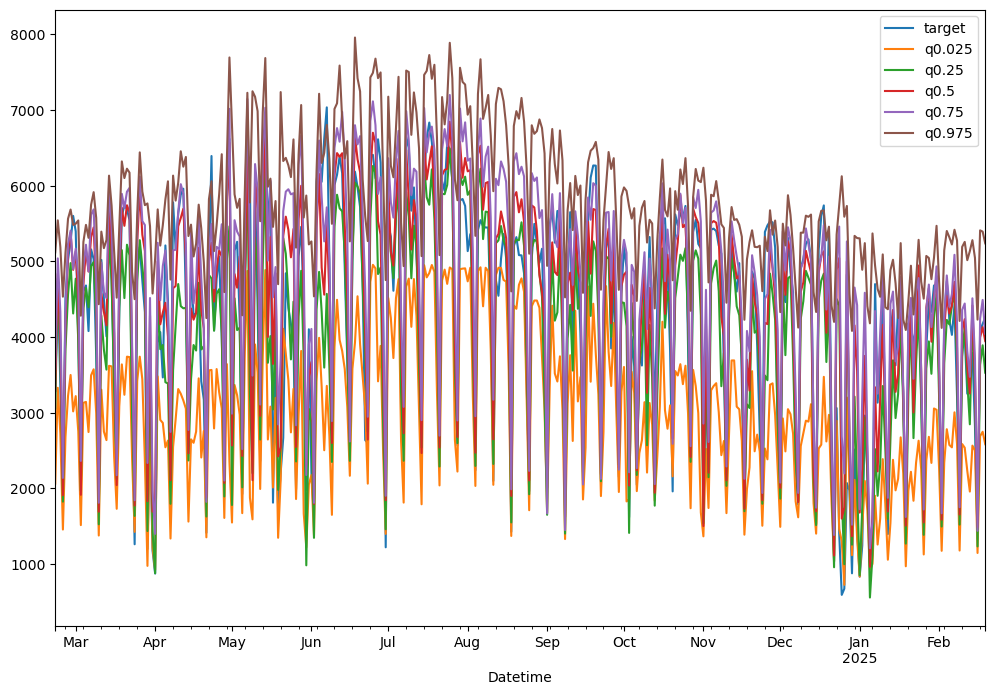

In [15]:
results.plot(figsize=(12,8))

#### Evaluation

In [16]:
# calucate quantile losses of all predictions
quantile_losses = {}

for q in quantiles:
    
    y_pred = results[f'q{q}']
    y_true = results['target']
    
    # pinball loss function multiplied by 2
    quantile_loss = np.where(y_pred > y_true, 
                             2 * (1 - q) * (y_pred - y_true), 
                             2 * q * (y_true - y_pred))
    
    quantile_losses[f'Quantile_{q}'] = quantile_loss.mean()

# losses of all quantile
total_loss_score = sum(quantile_losses.values())

# show results
print("Average loss by quantile:")
for quantile, loss in quantile_losses.items():
    print(f"{quantile}: {loss}")

print(f"\nTotal loss score over all quantiles: {total_loss_score}")

Average loss by quantile:
Quantile_0.025: 97.6424391965761
Quantile_0.25: 409.8169526521453
Quantile_0.5: 485.7082016896679
Quantile_0.75: 374.1129806619163
Quantile_0.975: 88.06235652848152

Total loss score over all quantiles: 1455.3429307287872


In [17]:
# filter only relevant target horizons
results['dayofweek'] = results.index.dayofweek

horizons_dict = {}

target_horizons = [
    {"dayofweek": 1, "name": "1 day"},  # Dienstag
    {"dayofweek": 2, "name": "2 day"},  # Mittwoch
    {"dayofweek": 3, "name": "3 day"},  # Donnerstag
    {"dayofweek": 4, "name": "4 day"},  # Freitag
    {"dayofweek": 5, "name": "5 day"},  # Samstag
    {"dayofweek": 6, "name": "6 day"},  # Sonntag
]


for horizon in target_horizons:
    
    horizon_data = results[(results["dayofweek"] == horizon["dayofweek"])]
    horizon_data = horizon_data.drop(columns=["dayofweek"])

    horizons_dict[horizon["name"]] = horizon_data

In [18]:
# quantile losses target horizons
def calculate_quantile_losses(horizons_dict, quantiles):
    all_quantile_losses = {}
    
    for key, df in horizons_dict.items():
        quantile_losses = {}
        for q in quantiles:
            y_pred = df[f'q{q}']
            y_true = df['target']
            quantile_loss = np.where(y_pred > y_true, 2 * (1 - q) * (y_pred - y_true), 2 * q * (y_true - y_pred))
            quantile_losses[f'q{q}'] = quantile_loss.mean()
        
        total_loss_score = sum(quantile_losses.values())
        quantile_losses['Total_Loss_Score'] = total_loss_score
        all_quantile_losses[key] = quantile_losses
    
    return all_quantile_losses

quantile_loss_results = calculate_quantile_losses(horizons_dict, quantiles)

horizon_results_df = pd.DataFrame(quantile_loss_results).T
horizon_results_df

,q0.025,q0.25,q0.5,q0.75,q0.975,Total_Loss_Score
1 day,150.111209,523.774847,553.634813,392.244812,81.347071,1701.112752
2 day,110.180826,378.165124,439.397799,315.132024,73.241563,1316.117336
3 day,100.918594,400.709848,479.857589,421.041516,86.270463,1488.798009
4 day,126.363414,480.078762,548.045016,415.007025,71.783866,1641.278083
5 day,63.925326,470.973642,657.379132,464.690542,103.070924,1760.039566
6 day,49.716683,219.333257,267.042600,255.093137,136.296523,927.482201


#### Final Evaluation Score

In [19]:
horizon_results_df.sum()

q0.025               601.216051
q0.25               2473.035482
q0.5                2945.356948
q0.75               2263.209056
q0.975               552.010410
Total_Loss_Score    8834.827948
dtype: float64